## Importing Required Packages

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Setting up data extractor

In [5]:
def get_files(path):
    file_list = []
    for path, directories, files in os.walk(path):
        file_list = files
        return file_list

In [6]:
e_image = cv2.imread(f'COVID19_Lung_CT/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png',0)
img_raw = cv2.imread(e_image)
print(img_raw.shape)
a = np.array(img_raw).flatten()
print(a.shape)

TypeError: Can't convert object of type 'numpy.ndarray' to 'str' for 'filename'

In [4]:
from keras.applications import VGG16 #VGG616 is our convolutional base trained on imagenet. You can also use Xception, Inception V3, ResNet50, etc.

conv_base = VGG16(weights='imagenet',
                  include_top=False,)

In [5]:
conv_base.summary() #Summary of the architecture and resulting feature maps

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [6]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 20 
generator = ImageDataGenerator(rescale=1./255)
def extract_features(x,y, s_count): #Feature extraction Function
    features = np.zeros(shape=(s_count, 3,3,512))
    labels = np.zeros(shape=(s_count))
    gen = generator.flow(x,y,batch_size = 20) #using flow instead of flow_to_directory because preprocessed images aren't in a directory
    counter = 0
    for inputs_batch, labels_batch in gen:
        features_batch = conv_base.predict(inputs_batch)
        features[counter*20:(counter+1)*20] = features_batch
        labels[counter*20:(counter+1)*20] = labels_batch
        counter +=1
        if counter * 20 >= s_count:
            break
    return features, labels

In [7]:
c_path = os.path.abspath('CT_COVID') #path

## Extracting COVID-19 data, normalizing & then adding to dataframe

In [8]:
#c_path = os.path.abspath('CT_COVID')
c_files = get_files(c_path)
c_data = []
for img in c_files:
    img_raw = cv2.imread(f'{c_path}/{img}',1)
    try:
        img_norm = cv2.resize(img_raw,(100,100)) # This needs to be improved with effective feature extraction
        img_flat = np.array(img_norm)
        c_data.append([img_flat,1]) # Assigning label 1 for COVID data
    except AssertionError: # Using try except clause makes sure we don't have any images which would not resize properly
        pass
print(len(c_data))

349


In [9]:
#pd.set_option("max_rows", None)
df = pd.DataFrame(c_data, columns = ['img_data', 'label'])
c_img_data_lst = np.array(df['img_data'].to_list()) #Turn img_data to np_array
c_label_lst = np.array(df['label'].to_list()) #Turn labels to np_array

In [7]:
c_img_data_lst

NameError: name 'c_img_data_lst' is not defined

In [10]:
c_features, c_labels = extract_features(c_img_data_lst, c_label_lst, 349)

In [11]:
c_features.shape

(349, 3, 3, 512)

In [12]:
c_features_flatten = np.reshape(c_features, (349, 3*3*512)) #flatten the array

In [13]:
c_features_flatten.shape

(349, 4608)

In [14]:
df['features'] = c_features_flatten.tolist()

In [15]:
df['img_data'][0].shape

(100, 100, 3)

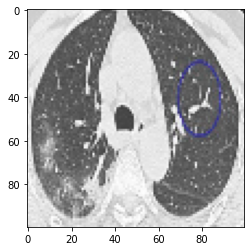

In [16]:
plt.imshow(df['img_data'][0])

In [17]:
df['img_data'][0].shape

(100, 100, 3)

In [18]:
a = df['img_data'][0].flatten() #flatten 
a.shape

(30000,)

## Extracting Non COVID-19 data, normalizing & then adding to dataframe

In [19]:
nc_path = "./CT_NonCOVID" #change your path back.
nc_files = get_files(nc_path)
nc_data = []

for img in nc_files:
    img_raw = cv2.imread(f'{nc_path}/{img}',1)
    try:
        img_norm = cv2.resize(img_raw,(100,100))
        img_flat = np.array(img_norm)
        nc_data.append([img_flat,0])
    except AssertionError:
        pass
    
print(len(nc_data))

397


In [20]:
df2 = pd.DataFrame(nc_data, columns = ['img_data', 'label'])
nc_img_data_lst = np.array(df2['img_data'].to_list()) #Turn img_data to np_array
nc_label_lst = np.array(df2['label'].to_list()) #Turn labels to np_array

In [21]:
nc_features, nc_labels = extract_features(nc_img_data_lst, nc_label_lst, 397)

In [22]:
nc_features.shape

(397, 3, 3, 512)

In [23]:
nc_features_flatten = np.reshape(nc_features, (397, 3*3*512)) #flatten the array

In [24]:
nc_features_flatten.shape

(397, 4608)

In [27]:
df2['features'] = nc_features_flatten.tolist()

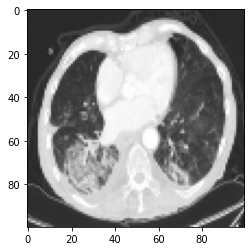

In [28]:
plt.imshow(df2['img_data'][0])

### Merging data frames

In [29]:
img_master = df.append(df2, ignore_index=True)
img_master

,img_data,label,features
0,"[[[222, 222, 222], [205, 205, 205], [209, 209,...",1,"[0.992064356803894, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1,"[[[79, 79, 79], [72, 72, 72], [116, 116, 116],...",1,"[0.7440223097801208, 0.0, 0.4354497194290161, ..."
2,"[[[223, 223, 223], [220, 220, 220], [220, 220,...",1,"[0.90545254945755, 0.0, 0.28750163316726685, 0..."
3,"[[[42, 42, 42], [38, 38, 38], [42, 42, 42], [4...",1,"[0.25389403104782104, 0.0, 0.2080378532409668,..."
4,"[[[45, 45, 45], [41, 41, 41], [39, 39, 39], [4...",1,"[0.12464411556720734, 0.0, 0.30682557821273804..."
...,...,...,...
741,"[[[3, 3, 3], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",0,"[0.7981113195419312, 0.0, 0.014930188655853271..."
742,"[[[3, 3, 3], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",0,"[0.7420978546142578, 0.0, 0.18491482734680176,..."
743,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",0,"[1.3097877502441406, 0.0, 0.36462879180908203,..."
744,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,"[0.5528252124786377, 0.0, 0.06080210208892822,..."


In [30]:
img_final = img_master.sample(frac=1).reset_index(drop=True) #Shuffling dataframe and resetting index values flatten it post cnn
img_final

,img_data,label,features
0,"[[[251, 251, 251], [254, 254, 254], [255, 255,...",1,"[0.7843492031097412, 0.0, 0.519983172416687, 0..."
1,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",1,"[1.7253309488296509, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",0,"[0.05483928322792053, 0.0, 0.525255560874939, ..."
3,"[[[55, 55, 55], [55, 55, 55], [54, 54, 54], [5...",0,"[1.1939685344696045, 0.0, 0.05081853270530701,..."
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,"[0.29267579317092896, 0.0, 0.08828175067901611..."
...,...,...,...
741,"[[[10, 10, 10], [59, 59, 59], [64, 64, 64], [6...",1,"[1.7864307165145874, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
742,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",0,"[1.0550132989883423, 0.0, 1.391021966934204, 0..."
743,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 1, 1], ...",0,"[0.8243714570999146, 0.0, 0.29550397396087646,..."
744,"[[[51, 51, 51], [50, 50, 50], [51, 51, 51], [5...",1,"[1.0456029176712036, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


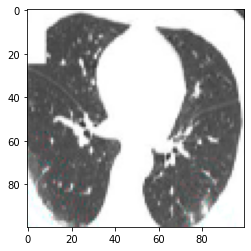

In [31]:
plt.imshow(img_final['img_data'][0])

### Applying feature extraction layer

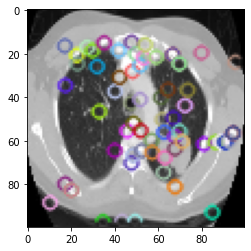

In [15]:
test = np.array(img_final['img_data'][0])
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(test, None)
test = cv2.drawKeypoints(test, kp, None)
plt.imshow(test)

### Training & Testing Split

In [ ]:
y_df = img_final[['label']]
X_df = img_final[['img_data']] # add reduced post extracted image array

In [ ]:
X = np.asarray(X_df)
y = np.asarray(y_df)
y = y.flatten()

In [ ]:
X_final = []
for i in X: # Just use reshape here instead
    for g in i:
        X_final.append(g)
    

In [ ]:
X_f = np.array(X_final)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     X_f, y, random_state=600)

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

### Implementing SVM Model

In [ ]:
sv = SVC(C=1,kernel='poly',gamma = 'auto')

In [ ]:
sv.fit(X_train, y_train)

In [ ]:
predict = sv.predict(X_test)

In [ ]:
print(f'Model accuracy is {accuracy_score(y_test, predict)*100:.2f}%')

In [ ]:
predict

In [ ]:
y_test

In [ ]:
import numpy as np
import pandas as pd

def train_validate_test_split(df, train_percent=.7, validate_percent=.1, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
train, validate, test = train_validate_test_split(img_final)

### Using Feature Extraction

In [33]:
y_df = img_final[['label']]
X_df = img_final['features']
X = np.asarray(X_df)
y = np.asarray(y_df)
X_f = np.array(X_df.to_list())

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
     X_f, y, random_state=600)

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (559, 4608)
X_test.shape  = (187, 4608)
y_train.shape = (559, 1)
y_test.shape  = (187, 1)


In [36]:
sv = SVC(C=1,kernel='poly',gamma = 'auto')

In [37]:
sv.fit(X_train, y_train)

C:\Users\hgu55\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=1, gamma='auto', kernel='poly')

In [38]:
predict = sv.predict(X_test)

In [39]:
print(f'Model accuracy is {accuracy_score(y_test, predict)*100:.2f}%')

Model accuracy is 51.87%
